In [2]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [3]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [40]:
# VAE model = encoder + decoder
# build encoder model
latent_dim = (18,18,64)
input_shape=(18,18,736)

def add_noise(args):
    alpha = 0.5
    _input = args
    noise = K.random_normal(shape=(input_shape))
    _out = _input + (alpha*noise)
    _out = K.clip(_out, min_value=0., max_value=1.)
    return _out

def create_dae(input_shape, latent_dim):
    inputs = Input(shape=input_shape, name='encoder_input')
    
    x = Lambda(add_noise, name='lambda_adding_noise')(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    z = Dense(latent_dim[-1], activation='relu', name='latent_layer')(x)

    # instantiate encoder model
    encoder = Model(inputs, z, name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=latent_dim, name='z_sampling')

    h = Dense(128, activation='relu')(latent_inputs)
    h = BatchNormalization()(h)
    h = Dense(256, activation='relu')(h)
    h = BatchNormalization()(h)
    h = Dense(736, activation='sigmoid')(h)
    h = BatchNormalization()(h)

    # instantiate decoder model
    decoder = Model(latent_inputs, h, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs))
    
    vae = Model(inputs, outputs, name='dae')
    vae.summary()
    vae.compile(loss=binary_crossentropy, optimizer=Adam())
    
    return vae, encoder, decoder

In [6]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices
print(label_dict)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.
{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


## Training original amazon

In [13]:
def create_model(input_shape=(300,300,3), n_classes=31):

    input_model = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same')(input_model)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(n_classes)(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    return Model(inputs=input_model, outputs=x)

In [10]:
baseline_model = create_model(input_shape=(256,256,3))
baseline_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
baseline_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 256, 256, 64)      0   

## Training baseline amazon 

In [11]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_phase2/baseline_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()

history = baseline_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator) // batch_size,
                                      epochs=100, callbacks=[mcp], verbose=1)

exe_time = time.time() - start
history.history['exe_time'] = exe_time

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_phase2/baseline_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Epoch 1/100
49/49 [==============================] - 21s 432ms/step - loss: 3.3847 - accuracy: 0.0855 - val_loss: 7.6963 - val_accuracy: 0.0430
Epoch 2/100
49/49 [==============================] - 20s 405ms/step - loss: 3.1011 - accuracy: 0.1133 - val_loss: 2.9412 - val_accuracy: 0.0506
Epoch 3/100
49/49 [==============================] - 20s 407ms/step - loss: 3.0032 - accuracy: 0.1574 - val_loss: 2.1979 - val_accuracy: 0.0228
Epoch 4/100
49/49 [==============================] - 20s 407ms/step - loss: 2.8749 - accuracy: 0.1878 - val_loss: 2.6850 - val_accuracy: 0.0228
Epoch 5/100
49/49 [==============================] - 20s 408ms/step - loss: 2.8217 - accuracy: 0.2222 - val_loss: 2.2378 - val_accuracy: 0.0304
Epoch 6/100
49/49 [==============================] - 20s 408ms/step - loss: 2.7470 - accuracy: 0.2332 - val_loss: 2.3953 - val_accuracy: 0.0304
Epoch 7/100
49/49 [==============================] - 20s 409ms/step - loss: 2.6485 - accuracy: 0.2701 - val_loss: 2.5259 - val_accuracy:

In [14]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon_phase2/baseline_model.hdf5')
# score = baseline_model.evaluate_generator(test_generator, verbose=1)
# score

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## Fine tunning amazon for webcam dataset

In [4]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/finetune_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()

history = baseline_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator) // batch_size,
                                      epochs=100, callbacks=[mcp], verbose=1)

exe_time = time.time() - start
history.history['exe_time'] = exe_time

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_phase2/finetune_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/100
13/13 [==============================] - 7s 552ms/step - loss: 3.1973 - accuracy: 0.2308 - val_loss: 15.3368 - val_accuracy: 0.1250
Epoch 2/100
13/13 [==============================] - 5s 360ms/step - loss: 2.4200 - accuracy: 0.3873 - val_loss: 44.5931 - val_accuracy: 0.0982
Epoch 3/100
13/13 [==============================] - 3s 209ms/step - loss: 1.6590 - accuracy: 0.4471 - val_loss: 35.0951 - val_accuracy: 0.0893
Epoch 4/100
13/13 [==============================] - 3s 206ms/step - loss: 1.6978 - accuracy: 0.4706 - val_loss: 13.4538 - val_accuracy: 0.1875
Epoch 5/100
13/13 [==============================] - 3s 209ms/step - loss: 1.1820 - accuracy: 0.6683 - val_loss: 36.0146 - val_accuracy: 0.0804
Epoch 6/100
13/13 [==============================] - 3s 205ms/step - loss: 1.3102 - accuracy: 0.6275 - val_loss: 14.5357 - val_accuracy: 0.2589
Epoch 7/100
13/13 [==============================] - 

Epoch 53/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3699 - accuracy: 0.9608 - val_loss: 1.4266 - val_accuracy: 0.8214
Epoch 54/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3655 - accuracy: 0.9615 - val_loss: 0.7532 - val_accuracy: 0.9107
Epoch 55/100
13/13 [==============================] - 3s 212ms/step - loss: 0.3799 - accuracy: 0.9327 - val_loss: 1.0075 - val_accuracy: 0.8214
Epoch 56/100
13/13 [==============================] - 3s 205ms/step - loss: 0.3852 - accuracy: 0.9265 - val_loss: 1.0856 - val_accuracy: 0.8125
Epoch 57/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3482 - accuracy: 0.9706 - val_loss: 0.9824 - val_accuracy: 0.8661
Epoch 58/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3913 - accuracy: 0.9327 - val_loss: 0.8495 - val_accuracy: 0.8661
Epoch 59/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3496 - accuracy: 0.9363 - val_loss: 1.1351 - val_accuracy:

In [6]:
test_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/finetune_model.hdf5')
score = test_model.evaluate_generator(test_generator, verbose=1)
score

239/239 [==============================] - 3s 11ms/step


[0.07255211472511292, 0.8912134170532227]

In [15]:
vaes = []
output_indices = [7,14, 24]
for i in output_indices:
    input_shape = baseline_model.layers[i].output_shape
    latent_dim = (18,18,input_shape[-1])
    
    vae = create_vae(input_shape, latent_dim)
    
    reconstruction_loss = input_shape * binary_crossentropy(vae.inputs,vae.outputs)
    z_log_var = vae.get_layer('encoder').get_layer('z_log_var')
    z_mean = vae.get_layer('encoder').get_layer('z_mean')
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    vaes.append(vae)


ValueError: Dimensions must be equal, but are 128 and 18 for 'z/mul_1' (op: 'Mul') with input shapes: [?,?,128,128,128], [18,18,64].

In [5]:
# create feature extractor model
output_indices = [7,14, 24]
outputs = [baseline_model.layers[k].output for k in output_indices]
extractor = Model(inputs=baseline_model.inputs, outputs=outputs)

extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 256, 256, 64)      0   

In [6]:
# extract feature from source (amazon)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/amazon'
train_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(256,256), 
                                                    batch_size=1, 
                                                    shuffle=False)

validation_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(256,256), 
                                                        batch_size=1, 
                                                        shuffle=False)

test_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(256,256), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 1576 images belonging to 31 classes.
Found 395 images belonging to 31 classes.
Found 846 images belonging to 31 classes.


In [ ]:
strain_features = extractor.predict_generator(train_feature_generator, verbose=1)
with open('/tf/data/Quan/tf_models/amazon_phase2/train_extracted_features.hdf5', 'wb') as dt:
    pickle.dump(strain_features, dt)
# sval_features = extractor.predict_generator(validation_feature_generator, verbose=1)
# stest_features = extractor.predict_generator(test_feature_generator, verbose=1)

1576/1576 [==============================] - 19s 12ms/step


In [ ]:
del(strain_features)

In [ ]:
strain_features = extractor.predict_generator(train_feature_generator, verbose=1)
with open('/tf/data/Quan/tf_models/amazon_phase2/train_extracted_features.hdf5', 'wb') as dt:
    pickle.dump(strain_features, dt)

In [33]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

In [16]:
vae.inputs, vae.outputs

([<tf.Tensor 'encoder_input_3:0' shape=(?, 18, 18, 736) dtype=float32>],
 [<tf.Tensor 'decoder_3/batch_normalization_20/cond/Merge:0' shape=(?, 18, 18, 736) dtype=float32>])

## Amazon

In [41]:
vae, _, _ = create_dae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_phase2/dae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(s_features,s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_phase2/dae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
dense_76 (Dense)             (None, 18, 18, 256)       188672    
_________________________________________________________________
batch_normalization_76 (Batc (None, 18, 18, 256)       1024      
_________________________________________________________________
dense_77 (Dense)             (None, 18, 18, 128)       32896     
_________________________________________________________________
batch_normalization_77 (Batc (None, 18, 18, 128)       512       
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        8256

1576/1576 [==============================] - 2s 1ms/step - loss: -2.8862 - val_loss: -3.1265
Epoch 47/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.8982 - val_loss: -3.1534
Epoch 48/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9167 - val_loss: -3.1745
Epoch 49/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9231 - val_loss: -3.1488
Epoch 50/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9406 - val_loss: -3.1591
Epoch 51/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9346 - val_loss: -3.1484
Epoch 52/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9369 - val_loss: -3.1805
Epoch 53/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9654 - val_loss: -3.2134
Epoch 54/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2.9971 - val_loss: -3.2193
Epoch 55/100
1576/1576 [==============================] - 2

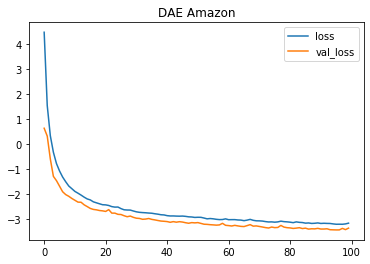

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('DAE Amazon')
plt.show()

## Webcam

In [43]:
vae, _, _ = create_dae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/dae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(t_features,t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features,tval_features, None), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_phase2/dae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
dense_81 (Dense)             (None, 18, 18, 256)       188672    
_________________________________________________________________
batch_normalization_81 (Batc (None, 18, 18, 256)       1024      
_________________________________________________________________
dense_82 (Dense)             (None, 18, 18, 128)       32896     
_________________________________________________________________
batch_normalization_82 (Batc (None, 18, 18, 128)       512       
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        8256

444/444 [==============================] - 1s 1ms/step - loss: -0.6633 - val_loss: -0.6635
Epoch 49/100
444/444 [==============================] - 1s 1ms/step - loss: -0.6882 - val_loss: -0.6955
Epoch 50/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7210 - val_loss: -0.7249
Epoch 51/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7256 - val_loss: -0.7219
Epoch 52/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7350 - val_loss: -0.7438
Epoch 53/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7386 - val_loss: -0.7521
Epoch 54/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7601 - val_loss: -0.7949
Epoch 55/100
444/444 [==============================] - 1s 1ms/step - loss: -0.7945 - val_loss: -0.8339
Epoch 56/100
444/444 [==============================] - 1s 1ms/step - loss: -0.8168 - val_loss: -0.8503
Epoch 57/100
444/444 [==============================] - 1s 1ms/step - loss: -

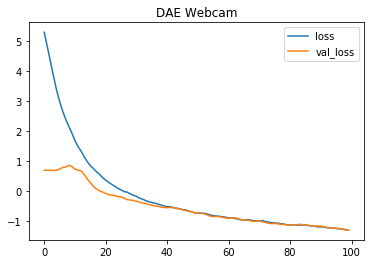

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('DAE Webcam')
plt.show()

## Combine VAE

In [47]:
import keras.losses

latent_dim = latent_dim = (18,18,64)

s_vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
s_vae.load_weights('/tf/data/Quan/tf_models/amazon_phase2/dae_model_weights.hdf5')
t_vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
t_vae.load_weights('/tf/data/Quan/tf_models/webcam_phase2/dae_model_weights.hdf5')


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
lambda_adding_noise (Lambda) (None, 18, 18, 736)       0         
_________________________________________________________________
dense_91 (Dense)             (None, 18, 18, 256)       188672    
_________________________________________________________________
batch_normalization_91 (Batc (None, 18, 18, 256)       1024      
_________________________________________________________________
dense_92 (Dense)             (None, 18, 18, 128)       32896     
_________________________________________________________________
batch_normalization_92 (Batc (None, 18, 18, 128)       512       
_________________________________________________________________
latent_layer (Dense)         (None, 18, 18, 64)        8256

In [48]:
s_vae.summary()

Model: "dae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              (None, 18, 18, 64)        231360    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       234976    
Total params: 466,336
Trainable params: 463,328
Non-trainable params: 3,008
_________________________________________________________________


In [49]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

In [50]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs))
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_dae')
c_vae.summary()

Model: "combined_dae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            (None, 18, 18, 64)        231360    
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       234976    
Total params: 466,336
Trainable params: 463,328
Non-trainable params: 3,008
_________________________________________________________________


In [51]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 929us/step


In [ ]:
transform_features.shape

In [ ]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

In [88]:
c_vae.trainable=False

# retrain source classifier

input_model = Input(shape=(18,18,736))

# add combined vae
t = c_vae(input_model)
concat = concatenate([t, input_model])
x = Conv2D(736, (1,1), padding='same')(concat)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
combined_dae (Model)            (None, 18, 18, 736)  466336      input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 18, 18, 1472) 0           combined_dae[10][0]              
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 18, 18, 736)  1084128     concatenate_6[0][0]       

In [65]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

# retrain source classifier

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 736)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 31)                22847     
_________________________________________________________________
batch_normalization_105 (Bat (None, 31)                124       
_________________________________________________________________
activation_5 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
______________________________________________________

In [89]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/amazon_dae_classifier_concat_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(t_features, t_num_labels, batch_size=32, epochs=200,
               validation_data=(tval_features, tval_num_labels), verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_phase2/amazon_dae_classifier_concat_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 3s 8ms/step - loss: 1.2204 - accuracy: 0.7252 - val_loss: 0.6698 - val_accuracy: 0.8661
Epoch 2/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1611 - accuracy: 0.9910 - val_loss: 0.5230 - val_accuracy: 0.8482
Epoch 3/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9932 - val_loss: 0.4816 - val_accuracy: 0.8482
Epoch 4/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1182 - accuracy: 0.9932 - val_loss: 0.4462 - val_accuracy: 0.8571
Epoch 5/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1115 - accuracy: 0.9977 - val_loss: 0.4363 - val_accuracy: 0.8750
Epoch 6/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1210 - accuracy: 0.9955 - val_loss: 0.4296 - val_accuracy: 0.8929
Epoch 7/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1127 - accuracy: 0.

444/444 [==============================] - 1s 1ms/step - loss: 0.0349 - accuracy: 0.9977 - val_loss: 0.4961 - val_accuracy: 0.8661
Epoch 58/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0405 - accuracy: 1.0000 - val_loss: 0.5085 - val_accuracy: 0.8661
Epoch 59/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 0.5070 - val_accuracy: 0.8571
Epoch 60/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.5117 - val_accuracy: 0.8750
Epoch 61/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 0.5012 - val_accuracy: 0.8750
Epoch 62/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.4989 - val_accuracy: 0.8839
Epoch 63/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.4913 - val_accuracy: 0.8839
Epoch

Epoch 114/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.4952 - val_accuracy: 0.8929
Epoch 115/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.5019 - val_accuracy: 0.8750
Epoch 116/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.4994 - val_accuracy: 0.8750
Epoch 117/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.4873 - val_accuracy: 0.8750
Epoch 118/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.4846 - val_accuracy: 0.8750
Epoch 119/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.4976 - val_accuracy: 0.8839
Epoch 120/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.4838 - val_ac

444/444 [==============================] - 1s 1ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.4784 - val_accuracy: 0.8839
Epoch 171/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.4925 - val_accuracy: 0.8661
Epoch 172/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.5024 - val_accuracy: 0.8661
Epoch 173/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.4922 - val_accuracy: 0.8661
Epoch 174/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.8661
Epoch 175/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.4945 - val_accuracy: 0.8750
Epoch 176/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.4899 - val_accuracy: 0.8661

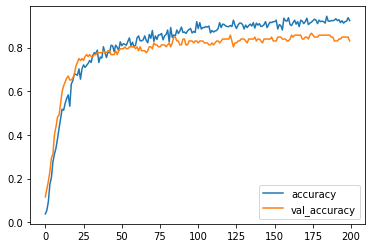

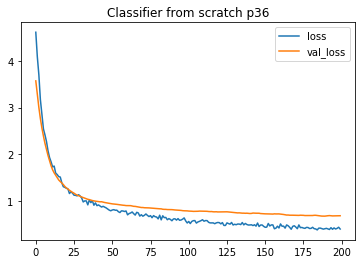

In [57]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch p36')
plt.show()

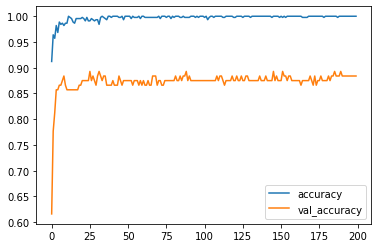

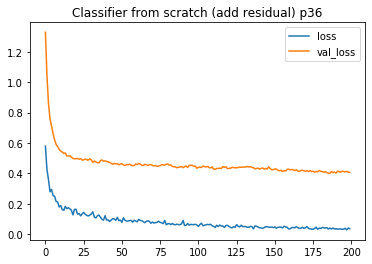

In [81]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (add residual) p36')
plt.show()

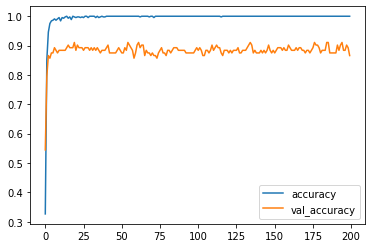

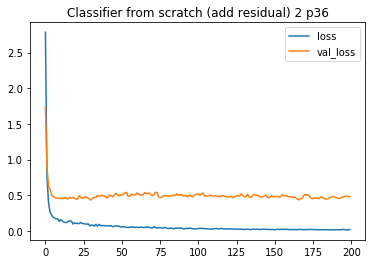

In [32]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (add residual) 2 p36')
plt.show()

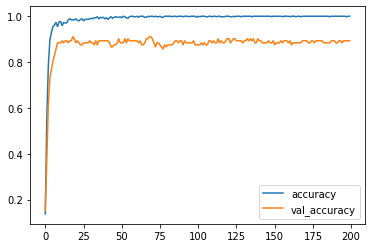

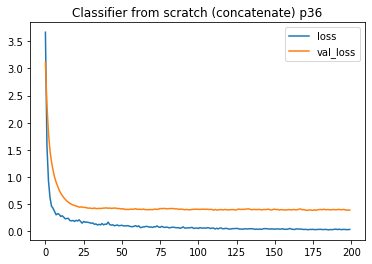

In [86]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (concatenate) p36')
plt.show()

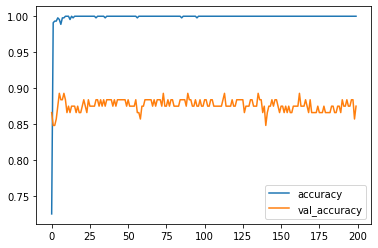

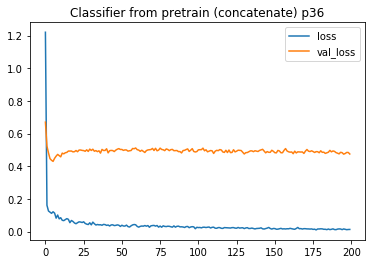

In [90]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from pretrain (concatenate) p36')
plt.show()

In [58]:
# convention
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_dae_classifier_scratch_model.hdf5')
stop_model.evaluate(test_transform_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 1s 2ms/step


[0.7988227009773254, 0.8033472895622253]

In [82]:
# residual
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_dae_classifier_scratch_residual_model.hdf5', custom_objects={'input_shape': (18,18,736), 'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 1s 5ms/step


[0.5095920820864673, 0.8702929019927979]

In [31]:
# residual 2
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_residual_model_2.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 1s 4ms/step


[0.5346084189714249, 0.8786610960960388]

In [28]:
# residual without retraining
s_topmodel.evaluate(ttest_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 4ms/step


[4.835845385635248, 0.02092050202190876]

In [87]:
# concat
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 1s 6ms/step


[1.0703956636923626, 0.8200836777687073]

In [91]:
# concat with finetune
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 1s 6ms/step


[0.5785402570808283, 0.8619247078895569]

In [ ]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

In [ ]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

In [ ]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

In [ ]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)